<a href="https://colab.research.google.com/github/demonlexe/cs4375-group17/blob/main/CS4375_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-setup and Word Embedding

Get your kaggle.json from going to settings in your Kaggle account and down to API and generate token

In [ ]:
!pip install kaggle

Upload your kaggle.json file to your Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
! mkdir ./drive/MyDrive/CS4375-final-project
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘./drive/MyDrive/CS4375-final-project’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download jacksoncrow/extended-wikipedia-multimodal-dataset

 99% 924M/933M [00:10<00:00, 106MB/s] 
100% 933M/933M [00:10<00:00, 90.9MB/s]


Dataset is saved to /content/data

In [ ]:
! unzip /content/extended-wikipedia-multimodal-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/Margaret_(singer)/img/meta.json  
  inflating: data/Margaret_(singer)/text.json  
  inflating: data/Margaret_Bondfield/img/meta.json  
  inflating: data/Margaret_Bondfield/text.json  
  inflating: data/Margaret_Fuller/img/meta.json  
  inflating: data/Margaret_Fuller/text.json  
  inflating: data/Margaret_Lea_Houston/img/meta.json  
  inflating: data/Margaret_Lea_Houston/text.json  
  inflating: data/Margaret_Murray/img/meta.json  
  inflating: data/Margaret_Murray/text.json  
  inflating: data/Margarita_with_a_Straw/img/meta.json  
  inflating: data/Margarita_with_a_Straw/text.json  
  inflating: data/Margate_F.C/img/meta.json  
  inflating: data/Margate_F.C/text.json  
  inflating: data/Maria_Rundell/img/meta.json  
  inflating: data/Maria_Rundell/text.json  
  inflating: data/Maria__or,_The_Wrongs_of_Woman/img/meta.json  
  inflating: data/Maria__or,_The_Wrongs_of_Woman/text.json  
  inflating: data/Mariah_Carey/im

Now, let's create the word embeddings! Make sure you install the dependency.

## Create Word Embeddings

The goal is to create Word Embeddings for later use in the model, which is trained upon the HTML text content of the wikipedia pages, as well as the specific words used in the features (parsed_title, caption, headings).

In [ ]:
!pip install beautifulsoup4
!pip install pyquery

In [ ]:
### Word Embeddings for CS 4375.001 Team 17 Project.
### Extracts and analyzes sentences from the dataset of Wikipedia articles.
### References:
### https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
### https://stackoverflow.com/questions/328356/extracting-text-from-html-file-using-python
### https://radimrehurek.com/gensim/models/word2vec.html
### https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

import os # accessing directory structure
import json
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim import utils

def beautifyJson(htmlAsString):
  soup = BeautifulSoup(htmlAsString, features="html.parser")
  # kill all script and style elements
  for script in soup(["script", "style"]):
      script.extract()    # rip it out

  text = soup.get_text()
  lines = (line.strip() for line in text.splitlines())
  chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
  text = (chunk for chunk in chunks if chunk)
  return list(text)

# CONTROL VARS
### Get more console logs, Run faster in devMode
devMode = False
### If false, don't process words from HTML.
processHTML = True

if devMode:
  print("CWD: ",os.getcwd())

# A list of the keys in `meta.json` that will be used to train word embeddings.
consideredImageStringKeys = ["title", "description", "parsed_title", "caption", "headings"]
# A list of the keys in `text.json` that will be used to train word embeddings.
consideredTextStringKeys = ["title"]

# Returns:
# sentences = A set of sentences corresponding to the meta.json images as well as text.json
def make_sentences(dataPath):
    sentences = set()
    count = 0
    numItems = len([name for name in os.listdir(dataPath)])
    for item in os.listdir(dataPath):
        count = count + 1
        if count > 200 and devMode:
          break
        textJson = getJSON(os.path.join("./data",item,"text.json"))
        imgJson = getJSON(os.path.join("./data",item,"img","meta.json"))
        if textJson and imgJson:
          if count % 500 == 1:
            print("Processing item ",count," of ",numItems, "(receiving updates at every 500 items)")
          imgMeta = imgJson.get('img_meta')
          for thisImg in imgMeta:
            for key in consideredImageStringKeys:
              words = thisImg.get(key)
              if type(words) is list:
                for theseWords in words:
                  if theseWords and len(theseWords) > 0:
                    sentences.add(theseWords)
              elif words and len(words) > 0:
                sentences.add(words)
          for key in consideredTextStringKeys:
            words = textJson.get(key)
            if type(words) is list:
              for theseWords in words:
                if theseWords and len(theseWords) > 0:
                  sentences.add(theseWords)
            elif words and len(words) > 0:
              sentences.add(words)
          # Process HTML now.
          if processHTML:
            doc = pq(textJson.get("html"))
            doc(".reflist").remove()
            doc(".vector-toc-contents").remove()
            doc(".mw-headline").remove()
            htmlSentences = beautifyJson(doc("#mw-content-text").text())
            if type(htmlSentences) is list and len(htmlSentences) > 0:
              for sentence in htmlSentences:
                if len(sentence) > 0:
                  sentences.add(sentence)
    return sentences

def getJSON(path):
    with open(path) as json_file:
        return json.loads(json.load(json_file))

allSentences = make_sentences("./data")
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        for line in allSentences:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)
sentences = MyCorpus()
embeddingsModel = Word2Vec(sentences, min_count=1)
print("Summarize the embedding model: ", embeddingsModel)
word_vectors = embeddingsModel.wv
del embeddingsModel
print("Saving the embedding model to embeddings.kv")
word_vectors.save("./drive/MyDrive/CS4375-final-project/embeddings.kv")
# TO later load the embeddings,
#
# from gensim.models import KeyedVectors
#
# reloaded_word_vectors = KeyedVectors.load('vectors.kv')

Processing item  1  of  5638 (receiving updates at every 500 items)
Processing item  501  of  5638 (receiving updates at every 500 items)
Processing item  1001  of  5638 (receiving updates at every 500 items)
Processing item  1501  of  5638 (receiving updates at every 500 items)
Processing item  2001  of  5638 (receiving updates at every 500 items)
Processing item  2501  of  5638 (receiving updates at every 500 items)
Processing item  3001  of  5638 (receiving updates at every 500 items)
Processing item  3501  of  5638 (receiving updates at every 500 items)
Processing item  4001  of  5638 (receiving updates at every 500 items)
Processing item  4501  of  5638 (receiving updates at every 500 items)
Processing item  5001  of  5638 (receiving updates at every 500 items)
Processing item  5501  of  5638 (receiving updates at every 500 items)
Summarize the embedding model:  Word2Vec<vocab=401340, vector_size=100, alpha=0.025>
Saving the embedding model to embeddings.kv


## Pre-Processing Data to .json Format

In [ ]:
!pip install pyquery

Firstly, only pull out images that have a valid and descriptive Alt tag. Then, save the wanted features, and the golden label.

In [ ]:
import os # accessing directory structure
import json
import re # regex
import urllib.parse
from pyquery import PyQuery as pq
from pprint import pprint

def getJSON(path):
    with open(path) as json_file:
        return json.loads(json.load(json_file))

debug = False
count = 0
imgCount = 0

# A list of the keys in `meta.json` that will be used as features.
consideredImageStringKeys = ["parsed_title", "url", "caption", "headings"]

trainingData = []
missingOrBadAltData = []

skippedImagesDueToMissingTitle = 0
couldNotFindImageInDocumentCount = 0
badAltTag = '(\.jpg|\.svg|\.png|\.avif|\.gif|\.jpeg|\.jfif|\.pjpeg|\.pjp|\.webp|\.apng)$'

for item in os.listdir("./data"):
  if debug and count > 500:
    break
  textJson = getJSON(os.path.join("./data",item,"text.json"))
  imgJson = getJSON(os.path.join("./data",item,"img","meta.json"))
  if textJson and imgJson:
    doc = pq(textJson.get("html"))
    imgMeta = imgJson.get("img_meta")
    count = count + 1
    imgCount = imgCount + len(imgMeta)
    for thisImg in imgMeta:
      newTrainingEntry = {}
      for key in consideredImageStringKeys:
        newTrainingEntry[key] = thisImg.get(key);
      title = thisImg.get("title")
      if not title:
        skippedImagesDueToMissingTitle = skippedImagesDueToMissingTitle + 1
        if debug:
          print("item: ",item," has an image missing a TITLE.")
        continue
      title = title.replace(" ", "_")
      title = urllib.parse.quote_plus(title) # make safe for query!
      tag = doc(f'img[src*="{title}"]')
      if tag:
        if tag.attr["alt"] and re.search(badAltTag, tag.attr["alt"], re.IGNORECASE) == None: # At this point, we found the image, and it has a descriptive alt tag in the HTML document.
          newTrainingEntry["alt_tag"] = tag.attr["alt"]
          trainingData.append(newTrainingEntry)
        elif tag.attr["alt"]:
          if debug:
            print("item:",item," has an image with an unhelpful alt tag. It's TITLE is:",title)
          missingOrBadAltData.append(newTrainingEntry)
        else:
          if debug:
            print("item:",item," has an image missing an alt tag. It's TITLE is:",title)
          missingOrBadAltData.append(newTrainingEntry)
      else:
        if debug:
          print("item:",item," has an image that could not be found in the document. It's TITLE is:",title)
        missingOrBadAltData.append(newTrainingEntry)
        couldNotFindImageInDocumentCount = couldNotFindImageInDocumentCount + 1

print("Final training data, with valid alt tags. Downloading to ProcessedData.json...")
with open("./drive/MyDrive/CS4375-final-project/ProcessedData.json", "w") as f:
    json.dump(trainingData, f)
print('Successfully downloaded to ./drive/MyDrive/CS4375-final-project/ProcessedData.json')
print("Final data, with missing alt tags. For analysis in report. Downloading to MissingOrBadAltTagsData.json...")
with open("./drive/MyDrive/CS4375-final-project/MissingOrBadAltTagsData.json", "w") as f:
    json.dump(missingOrBadAltData, f)
print('Successfully downloaded to ./drive/MyDrive/CS4375-final-project/MissingOrBadAltTagsData.json')

print("FINAL SCORE REPORT: ")
print("Total Articles Counted: ",count)
print("Total Images Counted: ",imgCount)
print("Failed images due to missing 'title' key, and thus undiscoverable:", skippedImagesDueToMissingTitle)
print("Failed images due to unable to locate in the document: ", couldNotFindImageInDocumentCount)
print("Length of Valid Data Array: ",len(trainingData))
print("Length of Data Array with missing or bad 'alt' tags: ", len(missingOrBadAltData) - couldNotFindImageInDocumentCount)

Final training data, with valid alt tags. Downloading to ProcessedData.json...
Successfully downloaded to ./drive/MyDrive/CS4375-final-project/ProcessedData.json
Final data, with missing alt tags. For analysis in report. Downloading to MissingOrBadAltTagsData.json...
Successfully downloaded to ./drive/MyDrive/CS4375-final-project/MissingOrBadAltTagsData.json
FINAL SCORE REPORT: 
Total Articles Counted:  5638
Total Images Counted:  54829
Failed images due to missing 'title' key, and thus undiscoverable: 0
Failed images due to unable to locate in the document:  1
Length of Valid Data Array:  20926
Length of Data Array with missing or bad 'alt' tags:  33902


# Neural Network Implementation

## **Neural Network Implementation**


*   Proobbaably gonna be using CNN to read spatial, but decoder - encoder for the image for better image captioning
*   tensorflow

References:

https://www.tensorflow.org/tutorials/images/cnn

https://towardsdatascience.com/tensorflow-vs-pytorch-convolutional-neural-networks-cnn-dd9ca6ddafce

https://medium.com/@nicolafan/end-to-end-implementation-of-an-image-caption-generator-with-cnn-and-rnn-using-tensorflow-and-keras-589f8ddea32b


## **Image Captioning from image features by Tensorflow**

Followed demo:

https://www.tensorflow.org/text/tutorials/image_captioning

In [2]:
!apt install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.7
!pip uninstall -y tensorflow estimator keras
!pip install -U tensorflow_text tensorflow tensorflow_datasets
!pip install einops

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.6.0.163-1+cuda11.7' for 'libcudnn8' was not found
Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# import required packages
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

In [4]:
# training ds
def flickr8k(path='./drive/MyDrive/CS4375-final-project/flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)

  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

# download the dataset for training
choose = 'flickr8k'

if choose == 'flickr8k':
  train_raw, test_raw = flickr8k()

train_raw.element_spec

for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

# image extractor implementation
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

# tokeniser / detonkeniser
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)

# Learn the vocabulary from the caption data.
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions


def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU.
  def gen():
    for (images, captions) in tqdm.tqdm(ds):
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)

  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

# train and test model
save_dataset(train_raw, './drive/MyDrive/CS4375-final-project/train_cache', mobilenet, tokenizer)
save_dataset(test_raw, './drive/MyDrive/CS4375-final-project/test_cache', mobilenet, tokenizer)

tf.Tensor(b'drive/MyDrive/CS4375-final-project/flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.
188it [06:53,  2.20s/it]
32it [00:46,  1.45s/it]


In [5]:
# load the model
train_ds = prepare_dataset(train_raw, tokenizer)
test_ds = prepare_dataset(test_raw, tokenizer)

train_ds = load_dataset('./drive/MyDrive/CS4375-final-project/train_cache')
test_ds = load_dataset('./drive/MyDrive/CS4375-final-project/test_cache')

In [6]:
# Build Encoder-Decoder model

class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias

output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 938/938 [00:20<00:00, 46.06it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


In [7]:
# Build Captioning Model
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True)

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

@Captioner.add_method
def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.1, num_layers=2, num_heads=2)

@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

In [ ]:
# test run to generate captions
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'captioner_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a a a a a
an a and and is brown at


## Training Image Capture Model
Now we are gonna train the model by adding:

*   The Loss and metrics
*   The Optimizer
*   Optional Callbacks


In [8]:
def masked_loss(labels, preds):
  labels = tf.cast(labels, tf.int32)
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()

callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

64400/64400 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'captioner', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.0416 - masked_acc: 0.1921



/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


a man in a man in a red
a man in the the water
two yellow smaller a checked boys in the fighting large is in the young gets near the another holding has in the poses

100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - loss: 5.0397 - masked_acc: 0.1924 - val_loss: 4.4842 - val_masked_acc: 0.2582
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - loss: 4.4909 - masked_acc: 0.2681

a man in a red shirt is in a red
a man in a blue of a
a little man playing ball through into the running plays above jumping

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 4.4902 - masked_acc: 0.2682 - val_loss: 4.2099 - val_masked_acc: 0.2966
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - loss: 4.2101 - masked_acc: 0.3023

a man in a red shirt is in a red shirt
a man in a blue shirt is standing in the water
a women competition playing in the buildings subway on a apron

100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - loss: 4.2098 - masked_acc: 0.3023 - val_loss: 4.1241 - val_masked_acc: 0.3003
Epoch 4

NameError: name 'image' is not defined

In [10]:
# Now let's save the trained model (don't run it more than once)
model.save('./drive/MyDrive/CS4375-final-project/image_capture.keras')

In [ ]:
# To load the model for future use
model = tf.keras.models.load_model('./drive/MyDrive/CS4375-final-project/image_capture.keras')

In [26]:
!pip install wikipedia
!pip install requests
!pip install json

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=272886cecaa34f31accb18fc853b52be19580efc84edcd598c448ec1f1f2ca41
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [27]:
# fetch image of the images
import wikipedia
import requests
import json

WIKI_REQUEST = 'http://en.wikipedia.org/w/api.php?action=query&prop=pageimages&format=json&piprop=original&titles='

def get_wiki_image(search_term):
    try:
        result = wikipedia.search(search_term, results = 1)
        wikipedia.set_lang('en')
        wkpage = wikipedia.WikipediaPage(title = result[0])
        title = wkpage.title
        response  = requests.get(WIKI_REQUEST+title)
        json_data = json.loads(response.text)
        img_link = list(json_data['query']['pages'].values())[0]['original']['source']
        return img_link
    except:
        return 0

# TODO: Loop it
wiki_image = get_wiki_image('clemuel ricketts house drawing 1')

In [32]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

In [35]:
image_url = wiki_image
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

# to just generate the caption
result = model.simple_gen(image, temperature=0.0)
print(result)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


a white and white dog is running through the snow


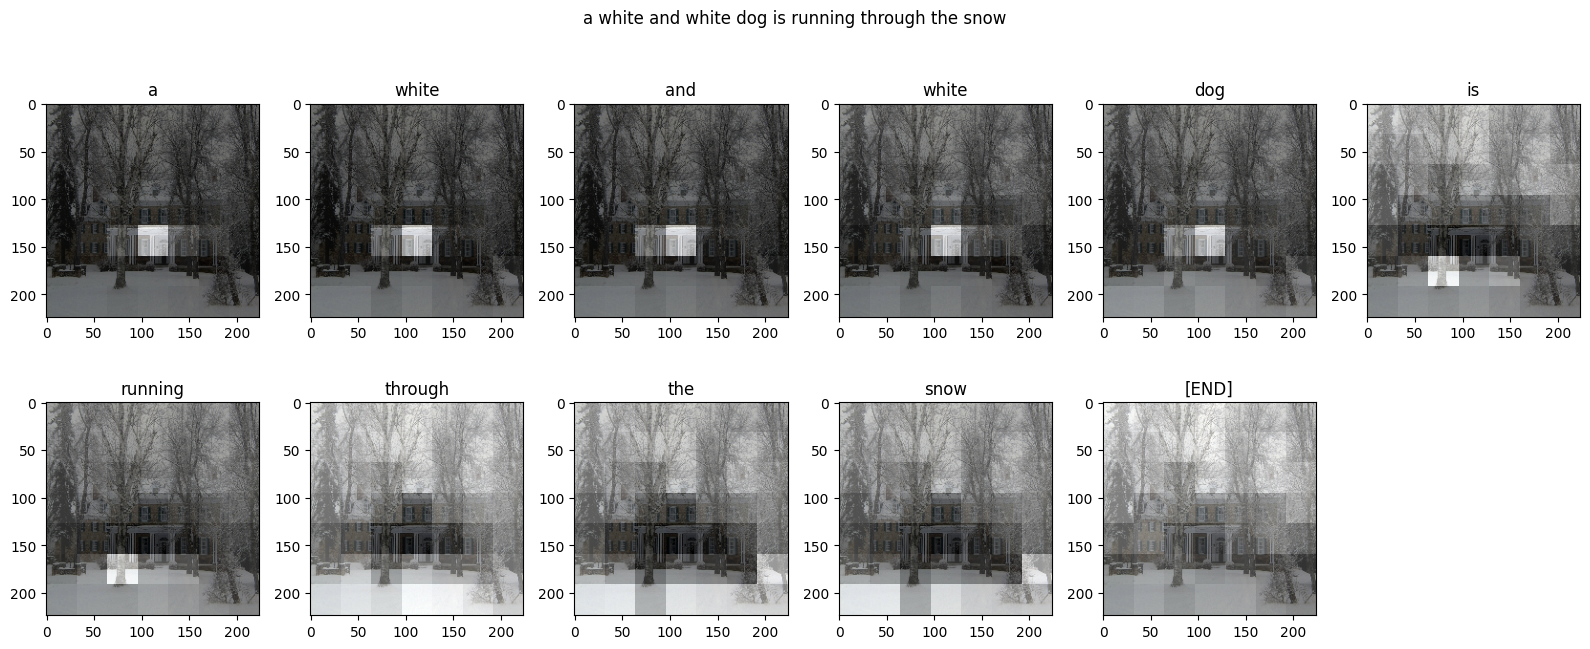

In [37]:
# to see the attention plot also
run_and_show_attention(model, image)

# **Pre-trained Word Embeddings Models Testing** (To compare with the implementation)
- GloVe
- BERT

References:
*   https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
*   https://www.geeksforgeeks.org/pre-trained-word-embedding-in-nlp/



**gloVe 6B embeddings**

gloVe 6B embeddings from Stanford:

https://nlp.stanford.edu/data/glove.6B.zip

## Pre-Trained Embeddings

In [ ]:
# Setting up gloVe
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

word_embeddings = {}

with open('/content/drive/MyDrive/CS4375-final-project/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs


f.close()
print('Loaded %s word vectors.' % len(word_embeddings))

Loaded 400000 word vectors.


In [ ]:
# Find similar words using euclidean distance function
def findClosestEmbeddings(embedding):
  return sorted(word_embeddings.keys(), key = lambda word: spatial.distance.euclidean(word_embeddings[word], embedding))

# Test Euclidean Distance Function
print(findClosestEmbeddings(word_embeddings["king"])[1:6])
print(findClosestEmbeddings(word_embeddings["man"])[1:6])
print(findClosestEmbeddings(word_embeddings["woman"])[1:6])
print(findClosestEmbeddings(word_embeddings["king"] - word_embeddings["man"] + word_embeddings["woman"])[1:6])

# Interesting example of Apple: Fruit vs Company?
# Could use arithmatic

#TODO: write one for BERT

['prince', 'queen', 'uncle', 'ii', 'grandson']
['woman', 'another', 'boy', 'one', 'old']
['girl', 'man', 'mother', 'boy', 'her']
['queen', 'prince', 'elizabeth', 'daughter', 'widow']


## Our Custom Embeddings

In [ ]:
# Compare to our own model

### https://radimrehurek.com/gensim/models/keyedvectors.html

from gensim.models import KeyedVectors
# Load the KeyedVectors from the file
loaded_keyed_vectors = KeyedVectors.load("./drive/MyDrive/CS4375-final-project/embeddings.kv")
print("loaded the embeddings! vocab is of length ",len(loaded_keyed_vectors.key_to_index))

print(loaded_keyed_vectors.most_similar(positive=['king'])[1:6])
print(loaded_keyed_vectors.most_similar(positive=['man'])[1:6])
print(loaded_keyed_vectors.most_similar(positive=['woman'])[1:6])
print(loaded_keyed_vectors.most_similar(positive=['woman', 'king'], negative=['man'])[1:6])

loaded the embeddings! vocab is of length  401340
[('prince', 0.707752525806427), ('queen', 0.7071049809455872), ('emperor', 0.7051095366477966), ('pope', 0.6923184990882874), ('monarch', 0.676988959312439)]
[('boy', 0.6735334992408752), ('person', 0.6622117161750793), ('someone', 0.6179286241531372), ('gentleman', 0.6163208484649658), ('girl', 0.6022722721099854)]
[('child', 0.7306786775588989), ('herself', 0.7176430225372314), ('man', 0.705341637134552), ('heroine', 0.6580249667167664), ('person', 0.6575755476951599)]
[('empress', 0.7243977189064026), ('throne', 0.6515994668006897), ('monarch', 0.6390817761421204), ('prince', 0.6335805058479309), ('princess', 0.6261253356933594)]


## BERT embeddings